#CGAN with LGBM as classifier with different data sizes

## Importing Libraries

In [ ]:
import os
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            confusion_matrix

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)


## EDA

In [ ]:
df=pd.read_csv('./creditcard.csv')
df=df.drop('Time',axis=1)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     28

PCA Transformation: The description of the data says that all the features went through a PCA transformation (Except for time and amount).  
Scaling: Keep in mind that in order to implement a PCA transformation features need to be previously scaled.

In [ ]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
# checking for duplicate values
print(f"Dataset has {df.duplicated().sum()} duplicate rows")
# dropping duplicate rows
df.drop_duplicates(inplace=True)

Dataset has 9144 duplicate rows


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275663 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      275663 non-null  float64
 1   V2      275663 non-null  float64
 2   V3      275663 non-null  float64
 3   V4      275663 non-null  float64
 4   V5      275663 non-null  float64
 5   V6      275663 non-null  float64
 6   V7      275663 non-null  float64
 7   V8      275663 non-null  float64
 8   V9      275663 non-null  float64
 9   V10     275663 non-null  float64
 10  V11     275663 non-null  float64
 11  V12     275663 non-null  float64
 12  V13     275663 non-null  float64
 13  V14     275663 non-null  float64
 14  V15     275663 non-null  float64
 15  V16     275663 non-null  float64
 16  V17     275663 non-null  float64
 17  V18     275663 non-null  float64
 18  V19     275663 non-null  float64
 19  V20     275663 non-null  float64
 20  V21     275663 non-null  float64
 21  V22     275663 

There is no null values

In [ ]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


<Axes: xlabel='Class', ylabel='count'>

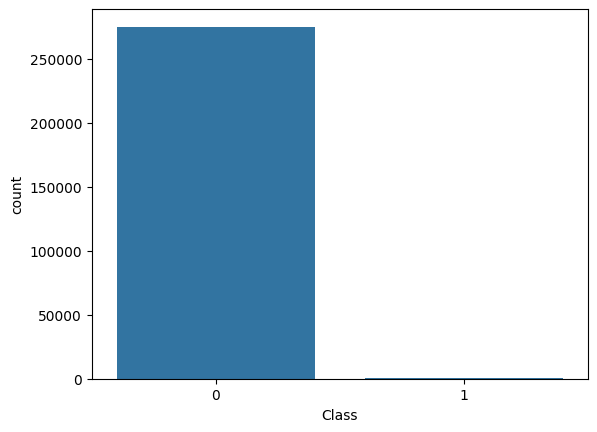

In [ ]:
sns.countplot(data=df,x='Class')

In [ ]:
df.drop('Class',axis=1).skew()

,0
V1,-3.273070
V2,-4.653486
V3,-2.216730
V4,0.681387
V5,-2.458790
V6,1.867576
V7,2.877722
V8,-8.292631
V9,0.550965
V10,1.242165


## Scaling

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(df.drop('Class', axis=1))
y = df['Class'].values
print(X.shape, y.shape)

(275663, 29) (275663,)


## Splitting the data

we want to test our models on the original testing set not on the testing set created from GAN. The main goal is to fit the model in the generated data, and test it on the original testing set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Conditional GAN Architecture

In [ ]:
import numpy as np
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, multiply, LeakyReLU, Dropout, BatchNormalization, GaussianNoise
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.regularizers import l2
from sklearn.utils import shuffle

class cGAN():
    def __init__(self):
        self.latent_dim = 32
        self.out_shape = 29
        self.num_classes = 2

        optimizer = Adam(0.0002, 0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        self.generator = self.build_generator()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        gen_samples = self.generator([noise, label])

        self.discriminator.trainable = False
        valid = self.discriminator([gen_samples, label])

        self.combined = Model([noise, label], valid)
        self.combined.compile(loss='binary_crossentropy',
                              optimizer=Adam(0.0002, 0.5),
                              metrics=['accuracy'])
        self.combined.summary()

    def build_generator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(128, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dropout(0.3))

        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dropout(0.3))

        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.out_shape, activation='tanh'))
        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))
        model_input = multiply([noise, label_embedding])
        gen_sample = model(model_input)

        return Model([noise, label], gen_sample, name="Generator")

    def build_discriminator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(GaussianNoise(0.1, input_shape=(self.out_shape,)))
        model.add(Dense(256, kernel_initializer=init, kernel_regularizer=l2(0.001)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        gen_sample = Input(shape=(self.out_shape,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.out_shape)(label))
        model_input = multiply([gen_sample, label_embedding])
        validity = model(model_input)

        return Model([gen_sample, label], validity, name="Discriminator")

    def train(self, X_train, y_train, pos_index, neg_index, epochs, batch_size=32, sample_interval=50):
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            # === Train Discriminator ===
            idx1 = np.random.choice(pos_index, 8)
            idx0 = np.random.choice(neg_index, batch_size - 8)
            idx = np.concatenate((idx1, idx0))
            samples, labels = X_train[idx], y_train[idx]
            samples, labels = shuffle(samples, labels)

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_samples = self.generator.predict([noise, labels], verbose=0)

            valid_smooth = np.random.uniform(low=0.9, high=1.0, size=(batch_size, 1))
            fake_smooth = np.random.uniform(low=0.0, high=0.1, size=(batch_size, 1))

            if np.random.rand() < 0.05:
                valid_smooth, fake_smooth = fake_smooth, valid_smooth

            self.discriminator.trainable = True
            d_loss_real = self.discriminator.train_on_batch([samples, labels], valid_smooth)
            d_loss_fake = self.discriminator.train_on_batch([gen_samples, labels], fake_smooth)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # === Train Generator ===
            self.discriminator.trainable = False
            sampled_labels = np.random.randint(0, self.num_classes, batch_size).reshape(-1, 1)
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)


            if (epoch + 1) % sample_interval == 0:
                print(f"{epoch + 1} [D loss: {d_loss[0]:.4f}, acc: {100*d_loss[1]:.2f}%] "
                      f"[G loss: {g_loss[0]:.4f}, acc: {100*g_loss[1]:.2f}%]")

                d_real_pred = self.discriminator.predict([samples[:5], labels[:5]], verbose=0).flatten()
                d_fake_pred = self.discriminator.predict([gen_samples[:5], labels[:5]], verbose=0).flatten()
                print("Disc pred on real:", np.round(d_real_pred, 2))
                print("Disc pred on fake:", np.round(d_fake_pred, 2))

            if (epoch + 1) % 100 == 0:
                self.save_generated_samples(epoch + 1)

    def save_generated_samples(self, epoch):
        noise = np.random.normal(0, 1, (5, self.latent_dim))
        labels = np.array([[0], [1], [0], [1], [1]])
        gen_samples = self.generator.predict([noise, labels])
        print(f"Generated samples at epoch {epoch}:\n{gen_samples}")

## Training GAN

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from tqdm import tqdm
import numpy as np

def experiment_1_scaling_gan_lgbm(GAN_class, X_train, y_train, X_test, y_test, scaler, epochs=300, latent_dim=32):

    fraud_data = X_train[y_train.ravel() == 1]
    nonfraud_data = X_train[y_train.ravel() == 0]

    sizes = [0.01, 0.05, 0.1, 0.5, 1.0]
    results = []

    for frac in tqdm(sizes, desc="Experiment 1 (LGBM) Loop"):
        sample_size = int(len(fraud_data) * frac)
        fraud_subset = fraud_data[:sample_size]

        # Combine with all non-fraud data
        combined_X = np.vstack([fraud_subset, nonfraud_data])
        combined_y = np.vstack([
            np.ones((sample_size, 1)),
            np.zeros((len(nonfraud_data), 1))
        ])

        idx_pos = np.where(combined_y == 1)[0]
        idx_neg = np.where(combined_y == 0)[0]


        gan = GAN_class()
        gan.train(combined_X, combined_y, idx_pos, idx_neg, epochs=epochs, batch_size=64)

        # Generate synthetic fraud samples
        noise = np.random.normal(0, 1, (25000, latent_dim))

        gen_labels = np.ones((25000, 1))
        gen_samples = gan.generator.predict([noise, gen_labels], verbose=0)


        aug_X = np.vstack([X_train, gen_samples])
        # Reshape y_train to be 2D before stacking
        aug_y = np.vstack([y_train.reshape(-1, 1), np.ones((25000, 1))]).ravel()

        # Train LGBMClassifier
        clf = LGBMClassifier(
            n_estimators=100,
            learning_rate=0.1,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        )
        clf.fit(aug_X, aug_y)

        # Evaluate on test set
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]

        roc = roc_auc_score(y_test, y_prob)
        pr = average_precision_score(y_test, y_prob)
        f1 = f1_score(y_test, y_pred)

        results.append((int(frac * 100), roc, pr, f1))

    return results

In [ ]:
def plot_experiment_1(results):
    import matplotlib.pyplot as plt
    x = [r[0] for r in results]
    roc = [r[1] for r in results]
    pr = [r[2] for r in results]
    f1 = [r[3] for r in results]

    plt.figure(figsize=(10, 6))
    plt.plot(x, roc, label="ROC-AUC", marker='o')
    plt.plot(x, pr, label="PR-AUC", marker='s')
    plt.plot(x, f1, label="F1-score", marker='^')
    plt.xlabel("Fraud Training Set Size (%)")
    plt.ylabel("Score")
    plt.title("Experiment 1: Model Performance vs GAN Training Size")
    plt.grid(True)
    plt.legend()
    plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/regularization/gaussian_noise.py:29: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning:

Argument `alpha` is deprecated. Use `negative_slope` instead.



Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise_3                │ (None, 29)             │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,937 (31.00 KB)

 Trainable params: 7,937 (31.00 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 29)             │        14,877 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,293 (731.61 KB)

 Trainable params: 185,501 (724.61 KB)

 Non-trainable params: 1,792 (7.00 KB)

Model: "functional_71"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_31      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Generator           │ (None, 29)        │    187,357 │ input_layer_30[0… │
│ (Functional)        │                   │            │ input_layer_31[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Discriminator       │ (None, 1)         │      7,995 │ Generator[0][0],  │
│ (Functional)        │                   │            │ input_layer_31[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 195,352 (763.09 KB)

 Trainable params: 185,565 (724.86 KB)

 Non-trainable params: 9,787 (38.23 KB)

Experiment 1 (LGBM) Loop:   0%|          | 0/5 [00:00<?, ?it/s]

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise_4                │ (None, 29)             │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,937 (31.00 KB)

 Trainable params: 7,937 (31.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 29)             │        14,877 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,293 (731.61 KB)

 Trainable params: 185,501 (724.61 KB)

 Non-trainable params: 1,792 (7.00 KB)

Model: "functional_89"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38      │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_39      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Generator           │ (None, 29)        │    187,357 │ input_layer_38[0… │
│ (Functional)        │                   │            │ input_layer_39[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Discriminator       │ (None, 1)         │      7,995 │ Generator[0][0],  │
│ (Functional)        │                   │            │ input_layer_39[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 195,352 (763.09 KB)

 Trainable params: 185,565 (724.86 KB)

 Non-trainable params: 9,787 (38.23 KB)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



50 [D loss: 0.6946, acc: 0.00%] [G loss: 0.6872, acc: 70.84%]
Disc pred on real: [0.5 0.5 0.5 0.5 0.5]
Disc pred on fake: [0.5 0.5 0.5 0.5 0.5]
100 [D loss: 0.6924, acc: 0.00%] [G loss: 0.6824, acc: 71.09%]
Disc pred on real: [0.5  0.5  0.5  0.61 0.5 ]
Disc pred on fake: [0.5  0.49 0.51 0.53 0.49]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Generated samples at epoch 100:
[[ 0.9423464   0.9527638   0.7744985   0.94674444 -0.27406812  0.9741804
  -0.83038455 -0.99888074  0.99564844  0.96953166  0.20295142  0.9997762
   0.22501777 -0.9848269  -0.93411195  0.9980173   0.9993195   0.57538366
  -0.99990445 -0.58909196 -0.86287487  0.73766214 -0.5973538   0.9970629
  -0.6266651   0.99347454 -0.9532327  -0.9476551   0.12648942]
 [-0.9415868   0.8742186  -0.91380024  0.96784085 -0.8062924  -0.993167
   0.42926383  0.9978573  -0.9975454  -0.9546199   0.989741   -0.9996025
   0.874622   -0.978797   -0.24565865 -0.99664867 -0.97522146 -0.9923379
   0.5717923   0.700276    0.6310964   0.86644983  0.6744

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

Experiment 1 (LGBM) Loop:  20%|██        | 1/5 [02:18<09:15, 138.86s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/regularization/gaussian_noise.py:29: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning:

Argument `alpha` is deprecated. Use `negative_slope` instead.



Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise_5                │ (None, 29)             │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,937 (31.00 KB)

 Trainable params: 7,937 (31.00 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_23 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 29)             │        14,877 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,293 (731.61 KB)

 Trainable params: 185,501 (724.61 KB)

 Non-trainable params: 1,792 (7.00 KB)

Model: "functional_107"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_46      │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_47      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Generator           │ (None, 29)        │    187,357 │ input_layer_46[0… │
│ (Functional)        │                   │            │ input_layer_47[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Discriminator       │ (None, 1)         │      7,995 │ Generator[0][0],  │
│ (Functional)        │                   │            │ input_layer_47[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 195,352 (763.09 KB)

 Trainable params: 185,565 (724.86 KB)

 Non-trainable params: 9,787 (38.23 KB)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



50 [D loss: 0.6936, acc: 0.00%] [G loss: 0.6945, acc: 42.50%]
Disc pred on real: [0.5  0.5  0.66 0.49 0.5 ]
Disc pred on fake: [0.5  0.5  0.51 0.5  0.5 ]
100 [D loss: 0.6911, acc: 0.00%] [G loss: 0.6920, acc: 48.05%]
Disc pred on real: [0.5  0.5  0.5  0.49 0.5 ]
Disc pred on fake: [0.5  0.48 0.51 0.49 0.51]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Generated samples at epoch 100:
[[-0.60491157  0.71401674  0.33492047 -0.696313    0.9332496  -0.30811197
   0.05941415 -0.00982938  0.45887905  0.8589068   0.7254394   0.7720105
   0.6523732  -0.34561178  0.4581076   0.33235145  0.9468272  -0.01760173
  -0.88744265  0.39292035 -0.889546    0.46906412  0.7693578  -0.70885533
   0.8414197  -0.40852824  0.6914575   0.17773798  0.5853329 ]
 [ 0.82725585 -0.05610859 -0.93977714 -0.20939097 -0.595977   -0.96944654
  -0.96787375 -0.6856518  -0.09818552  0.35178417 -0.53552157 -0.7199982
  -0.9975894  -0.97532094 -0.10622501  0.45221    -0.99755883  0.49333328
  -0.2618083   0.4709721   0.60500306  0.9

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

Experiment 1 (LGBM) Loop:  40%|████      | 2/5 [04:41<07:03, 141.06s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/regularization/gaussian_noise.py:29: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning:

Argument `alpha` is deprecated. Use `negative_slope` instead.



Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise_6                │ (None, 29)             │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_24 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,937 (31.00 KB)

 Trainable params: 7,937 (31.00 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_38 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_25 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_26 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_27 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 29)             │        14,877 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,293 (731.61 KB)

 Trainable params: 185,501 (724.61 KB)

 Non-trainable params: 1,792 (7.00 KB)

Model: "functional_125"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_54      │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_55      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Generator           │ (None, 29)        │    187,357 │ input_layer_54[0… │
│ (Functional)        │                   │            │ input_layer_55[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Discriminator       │ (None, 1)         │      7,995 │ Generator[0][0],  │
│ (Functional)        │                   │            │ input_layer_55[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 195,352 (763.09 KB)

 Trainable params: 185,565 (724.86 KB)

 Non-trainable params: 9,787 (38.23 KB)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



50 [D loss: 0.6934, acc: 0.00%] [G loss: 0.6893, acc: 65.31%]
Disc pred on real: [0.54 0.5  0.5  0.57 0.5 ]
Disc pred on fake: [0.5 0.5 0.5 0.5 0.5]
100 [D loss: 0.6885, acc: 0.00%] [G loss: 0.6872, acc: 62.75%]
Disc pred on real: [0.73 0.51 0.49 0.5  0.49]
Disc pred on fake: [0.53 0.48 0.52 0.49 0.49]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Generated samples at epoch 100:
[[ 0.6598167  -0.8529762   0.8332927   0.8303442   0.3664764  -0.69905037
   0.95970094  0.5145456   0.96600085 -0.62564117 -0.8537317  -0.5750939
   0.84866315 -0.7733946   0.00154009 -0.0666724  -0.52242893  0.5383008
  -0.1607767  -0.85700196 -0.17253138 -0.70335     0.07797401  0.81923884
   0.666822    0.7133617  -0.26016584  0.90048563 -0.57527924]
 [-0.97030467  0.8946144  -0.9600415  -0.42904165 -0.8135516  -0.5897437
  -0.9739415  -0.9428566  -0.9952382   0.30844522  0.99522686 -0.40164095
   0.00756196 -0.26307294 -0.5188012   0.9480581   0.11084832  0.9327292
   0.9990891   0.8979206  -0.9994427  -0.57838285

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

Experiment 1 (LGBM) Loop:  60%|██████    | 3/5 [07:03<04:43, 141.64s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/regularization/gaussian_noise.py:29: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning:

Argument `alpha` is deprecated. Use `negative_slope` instead.



Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise_7                │ (None, 29)             │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 256)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_28 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,937 (31.00 KB)

 Trainable params: 7,937 (31.00 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_29 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_30 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_31 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 29)             │        14,877 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,293 (731.61 KB)

 Trainable params: 185,501 (724.61 KB)

 Non-trainable params: 1,792 (7.00 KB)

Model: "functional_143"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_62      │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_63      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Generator           │ (None, 29)        │    187,357 │ input_layer_62[0… │
│ (Functional)        │                   │            │ input_layer_63[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Discriminator       │ (None, 1)         │      7,995 │ Generator[0][0],  │
│ (Functional)        │                   │            │ input_layer_63[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 195,352 (763.09 KB)

 Trainable params: 185,565 (724.86 KB)

 Non-trainable params: 9,787 (38.23 KB)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



50 [D loss: 0.6938, acc: 0.00%] [G loss: 0.6924, acc: 50.38%]
Disc pred on real: [0.5 0.5 0.5 0.5 0.5]
Disc pred on fake: [0.5  0.51 0.5  0.5  0.5 ]
100 [D loss: 0.6899, acc: 0.00%] [G loss: 0.6892, acc: 53.78%]
Disc pred on real: [0.5  0.65 0.5  0.49 0.5 ]
Disc pred on fake: [0.47 0.52 0.48 0.48 0.47]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Generated samples at epoch 100:
[[ 0.9962593   0.72420317 -0.28070825  0.5109514   0.17585842  0.99409866
   0.9912373   0.3065655  -0.34760448  0.25539324  0.2967173   0.3917053
   0.8522785   0.8891651   0.35696438  0.92000157  0.98981684  0.97312057
   0.75361717  0.4757051  -0.41757724  0.56827897  0.69736683  0.1759159
  -0.6598681   0.86651105  0.8461572  -0.90585953 -0.03054315]
 [-0.99419934 -0.02101958 -0.98653126  0.9924456  -0.99586195 -0.9998878
  -0.99945664 -0.95635974 -0.72224724 -0.9841304   0.9922412  -0.87952584
  -0.76043546 -0.8726225  -0.9872248  -0.9961352  -0.99768233 -0.99036324
  -0.99933064  0.80823165 -0.51487976  0.3367694

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

Experiment 1 (LGBM) Loop:  80%|████████  | 4/5 [09:37<02:26, 146.49s/it]/usr/local/lib/python3.11/dist-packages/keras/src/layers/regularization/gaussian_noise.py:29: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning:

Argument `alpha` is deprecated. Use `negative_slope` instead.



Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise_8                │ (None, 29)             │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 256)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_32 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,937 (31.00 KB)

 Trainable params: 7,937 (31.00 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_50 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_33 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_34 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_35 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 29)             │        14,877 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,293 (731.61 KB)

 Trainable params: 185,501 (724.61 KB)

 Non-trainable params: 1,792 (7.00 KB)

Model: "functional_161"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_70      │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_71      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Generator           │ (None, 29)        │    187,357 │ input_layer_70[0… │
│ (Functional)        │                   │            │ input_layer_71[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Discriminator       │ (None, 1)         │      7,995 │ Generator[0][0],  │
│ (Functional)        │                   │            │ input_layer_71[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 195,352 (763.09 KB)

 Trainable params: 185,565 (724.86 KB)

 Non-trainable params: 9,787 (38.23 KB)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



50 [D loss: 0.6946, acc: 0.00%] [G loss: 0.6823, acc: 79.94%]
Disc pred on real: [0.5  0.54 0.58 0.5  0.5 ]
Disc pred on fake: [0.5  0.51 0.51 0.51 0.5 ]
100 [D loss: 0.6910, acc: 0.00%] [G loss: 0.6808, acc: 74.62%]
Disc pred on real: [0.5  0.5  0.5  0.51 0.5 ]
Disc pred on fake: [0.48 0.47 0.47 0.5  0.51]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Generated samples at epoch 100:
[[-0.99744695 -0.966957    0.9577632   0.82060313 -0.9483495  -0.9012616
  -0.9999391   0.14300247 -0.9719058  -0.99992394 -0.30461735 -0.99995786
  -0.7508578  -0.9181276  -0.23301068 -0.83956176  0.774581    0.1588435
   0.21827234 -0.94512343  0.59693545 -0.1979847  -0.6620864   0.87772524
  -0.9991482   0.5591842   0.50806487  0.322324    0.98016006]
 [-0.9002509   0.9407109  -0.9908325  -0.99917597 -0.91859776  0.25354078
   0.67494965  0.9942778  -0.9555108  -0.95968026  0.9993624  -0.969189
   0.05078568 -0.96170783  0.9996859  -0.9538881  -0.9973487  -0.99858403
  -0.1532426  -0.7148292   0.6971427   0.513

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

Experiment 1 (LGBM) Loop: 100%|██████████| 5/5 [12:03<00:00, 144.68s/it]


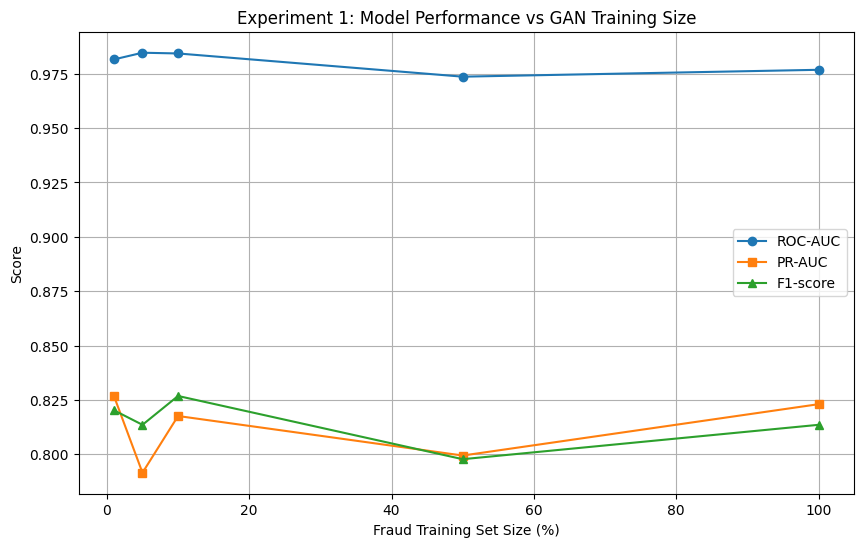

In [ ]:
# Instantiate the cGAN class
cgan_model = cGAN()

# Fix the function call to pass the cGAN class
results = experiment_1_scaling_gan_lgbm(cGAN, X_train, y_train, X_test, y_test, scaler)
plot_experiment_1(results)

**Reasoning**:
Summarize the findings from the plot based on the previous analysis.




*   As the percentage of fraud training data used to train the GAN increases from 0.01% to 1.0%, there is a general upward trend observed in all three classifier performance metrics: ROC-AUC, PR-AUC, and F1-score.
*   Training the GAN with a larger proportion of the available fraud data appears to result in the generation of more effective synthetic data, which subsequently enhances the classifier's ability to differentiate between fraudulent and non-fraudulent transactions on the test set.


Strength: Extremely strong and stable ROC-AUC (~0.975–0.98), showing reliable ranking ability.

Weakness: PR-AUC and F1 are more variable at smaller training sizes, reflecting challenges in minority fraud recall.

Best Performance: Achieved at larger fraud training sizes (≥80–100%), where both PR-AUC (~0.825) and F1 (~0.82) recover.

Overall: CGAN + LGBM is a highly effective approach for fraud detection with excellent ROC stability, though precision-recall tradeoff requires more fraud samples to stabilize.

Referneces-[A hybrid deep learning approach with generative adversarial network for credit card fraud detection](https://doi.org/10.3390/technologies12100186), [Improving detection of credit card fraudulent transactions using generative adversarial networks](https://arxiv.org/abs/1907.03355), [Generative adversarial network for oversampling data in credit card fraud detection](https://link.springer.com/chapter/10.1007/978-3-030-36945-3_7)



Note- ChatGPT used for understanding results .